In [1]:
import os
from collections import Counter

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re

from pylab import rcParams
from wordcloud import WordCloud
from nltk import word_tokenize
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.font_manager as font_manager
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter

# import datetime

In [2]:
# nltk.download('punkt')
# nltk.download('stopwords')

In [3]:
#Import database

df_comunicados = pd.read_csv('BD_Minutas.csv',encoding='latin-1')


#Si hubo movimiento en la actual o las próximos 2 reuniones ponerle 1. De lo contrario ponerle 0
df_comunicados['Movimiento'] = np.where((df_comunicados['Cambio'].shift(periods=0) != 0 )| 
                                        (df_comunicados['Cambio'].shift(periods=-1) != 0 )| 
                                        (df_comunicados['Cambio'].shift(periods=-2))  != 0, 1, 0)


#Converting words to lower case
df_comunicados['Texto_minus'] = df_comunicados['Texto'].apply(lambda x: x.lower())

#Converting words to tokens
df_comunicados['Texto_token'] = df_comunicados['Texto_minus'].apply(lambda x: word_tokenize(x))

#Create function to return a list without stop words for each text
def remove_stop_words(words):

    spanish_stop_words = set(stopwords.words("spanish"))
    lista_banrep= ['sesión', 'día','junta','directiva','banco','república', 'a. m.', 'p. m.', 'm.', 'a.', 'pb']
    
    lista_banrep.extend(spanish_stop_words)    
    stopword = []
    without_stop_words = []

    for word in words:
        if word in lista_banrep:
            stopword.append(word)
        else:
            without_stop_words.append(word)
    
    return without_stop_words

            
df_comunicados['Texto_without_stopwords'] = df_comunicados['Texto_token'].apply(lambda x: remove_stop_words(x))

#Quitamos nuevamente el token para que sea un texto simple. Esto para luego eliminar caracteres especiales,e tc
from nltk.tokenize.treebank import TreebankWordDetokenizer
df_comunicados['Texto_without_stopwords_sintoken'] = df_comunicados['Texto_without_stopwords'].apply(lambda x: TreebankWordDetokenizer().detokenize(x))

#Removing special caracthers
df_comunicados_backup = df_comunicados['Texto_without_stopwords_sintoken'].copy()
df_comunicados['Texto_limpio'] = df_comunicados['Texto_without_stopwords_sintoken'].apply(lambda x: re.sub('[á]+', 'a', x)) #Así reemplazamos todas las tildes por vocales sin tilde
df_comunicados['Texto_limpio'] = df_comunicados['Texto_limpio'].apply(lambda x: re.sub('[é]+', 'e', x))
df_comunicados['Texto_limpio'] = df_comunicados['Texto_limpio'].apply(lambda x: re.sub('[í]+', 'i', x))
df_comunicados['Texto_limpio'] = df_comunicados['Texto_limpio'].apply(lambda x: re.sub('[ó]+', 'o', x))
df_comunicados['Texto_limpio'] = df_comunicados['Texto_limpio'].apply(lambda x: re.sub('[ú]+', 'u', x))
df_comunicados['Texto_limpio'] = df_comunicados['Texto_limpio'].apply(lambda x: re.sub('[^A-Za-z0-9 ]+', ' ', x)) #Así removemos todos los caracteres especiales
df_comunicados['Texto_limpio'] = df_comunicados['Texto_limpio'].apply(lambda x: re.sub('[0-9]+', '', x))#Así removemos todos los números

In [4]:
df_comunicados['Fecha'] = pd.to_datetime(df_comunicados['Fecha'])
df_comunicados.sort_values(by='Fecha')

,Fecha,Texto,Cambio,Movimiento,Texto_minus,Texto_token,Texto_without_stopwords,Texto_without_stopwords_sintoken,Texto_limpio
0,2013-04-26,Banco de la República mantiene la tasa de inte...,0,0,banco de la república mantiene la tasa de inte...,"[banco, de, la, república, mantiene, la, tasa,...","[mantiene, tasa, interés, referencia, 3,25, %,...","mantiene tasa interés referencia 3,25% . hoy d...",mantiene tasa interes referencia hoy deci...
1,2013-05-31,Banco de la República mantiene la tasa de inte...,0,0,banco de la república mantiene la tasa de inte...,"[banco, de, la, república, mantiene, la, tasa,...","[mantiene, tasa, interés, referencia, continúa...",mantiene tasa interés referencia continúa prog...,mantiene tasa interes referencia continua prog...
2,2013-06-28,Banco de la República mantiene la tasa de inte...,0,0,banco de la república mantiene la tasa de inte...,"[banco, de, la, república, mantiene, la, tasa,...","[mantiene, tasa, interés, referencia, ., hoy, ...",mantiene tasa interés referencia . hoy decidió...,mantiene tasa interes referencia hoy decidio...
3,2013-07-26,Banco de la República mantiene la tasa de inte...,0,0,banco de la república mantiene la tasa de inte...,"[banco, de, la, república, mantiene, la, tasa,...","[mantiene, tasa, interés, referencia, 3,25, %,...","mantiene tasa interés referencia 3,25% . hoy d...",mantiene tasa interes referencia hoy deci...
4,2013-08-30,Banco de la República mantiene la tasa de inte...,0,0,banco de la república mantiene la tasa de inte...,"[banco, de, la, república, mantiene, la, tasa,...","[mantiene, tasa, interés, referencia, 3,25, %,...","mantiene tasa interés referencia 3,25% . hoy d...",mantiene tasa interes referencia hoy deci...
...,...,...,...,...,...,...,...,...,...
110,2023-12-19,La Junta Directiva del Banco de la República d...,-25,1,la junta directiva del banco de la república d...,"[la, junta, directiva, del, banco, de, la, rep...","[decidió, mayoría, reducir, 25, puntos, básico...",decidió mayoría reducir 25 puntos básicos (pbs...,decidio mayoria reducir puntos basicos pbs ...
111,2024-01-31,La Junta Directiva del Banco de la República d...,-25,1,la junta directiva del banco de la república d...,"[la, junta, directiva, del, banco, de, la, rep...","[decidió, mayoría, reducir, 25, puntos, básico...",decidió mayoría reducir 25 puntos básicos (pbs...,decidio mayoria reducir puntos basicos pbs ...
112,2024-03-22,La Junta Directiva del Banco de la República d...,-50,1,la junta directiva del banco de la república d...,"[la, junta, directiva, del, banco, de, la, rep...","[decidió, mayoría, reducir, 50, puntos, básico...",decidió mayoría reducir 50 puntos básicos (pbs...,decidio mayoria reducir puntos basicos pbs ...
113,2024-04-30,La Junta Directiva del Banco de la República d...,-50,1,la junta directiva del banco de la república d...,"[la, junta, directiva, del, banco, de, la, rep...","[decidió, mayoría, reducir, 50, puntos, básico...",decidió mayoría reducir 50 puntos básicos (pbs...,decidio mayoria reducir puntos basicos pbs ...


In [5]:
df_comunicados.shape

(115, 9)

<AxesSubplot: >

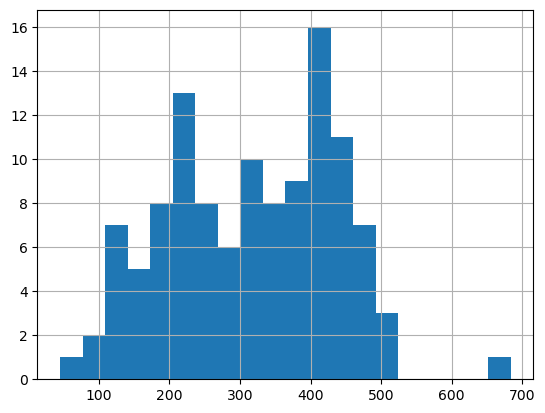

In [6]:
words_per_review = df_comunicados['Texto_limpio'].apply(lambda x: len(x.split(" ")))
words_per_review.hist(bins = 20)

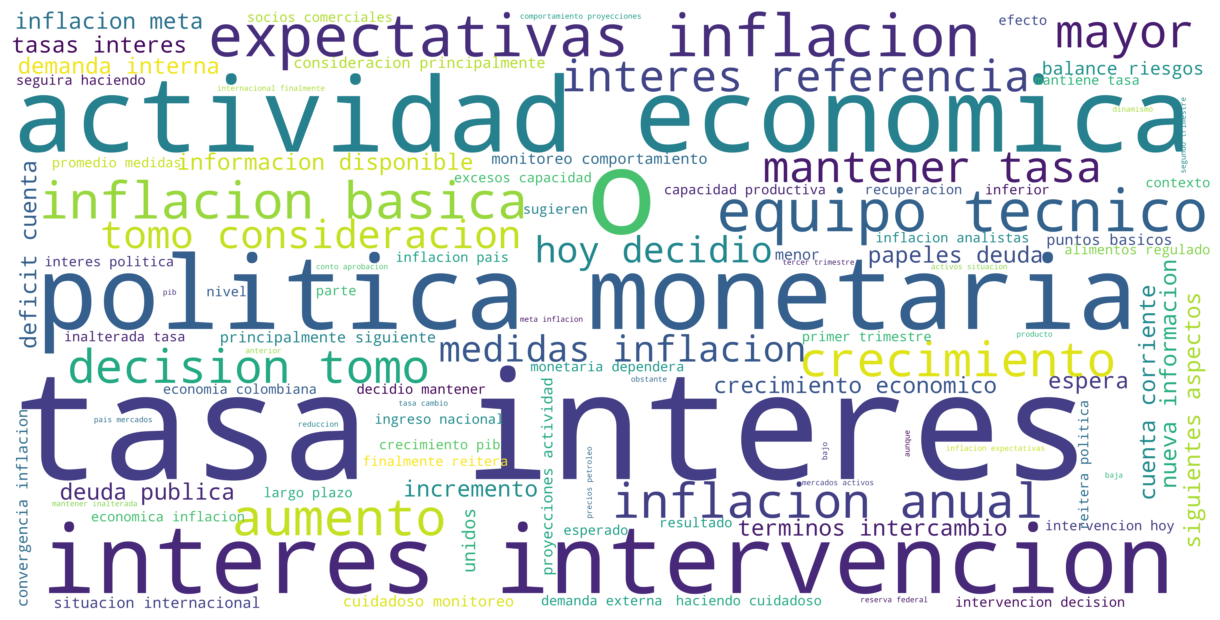

In [7]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

word_cloud_text = ''.join(df_comunicados['Texto_limpio'])
wordcloud = WordCloud(max_font_size=100, max_words=100, background_color="white",\
                          scale = 20,width=800, height=400).generate(word_cloud_text)

plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

plt.subplots_adjust(bottom=0.1, right=2.0, top=2.0)

plt.show()

In [8]:
#CountVectorizer is a Python class that automatically accounts for certain preprocessing steps like removing stopwords, stemming, creating n-grams, and word tokenization:
from nltk.stem import PorterStemmer

#Use logistic regression to build a binary classifier 
#The binary variable is if the Central Bank moved the rate or not (in t+0 , t+1 or t+2)

stemmer = PorterStemmer()
analyzer = CountVectorizer().build_analyzer()

def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

# CountVectorizer es an SKLearn function that help us convert words into a vector
bow_counts = CountVectorizer(tokenizer=word_tokenize, ngram_range=(1, 4))

df_comunicados_train = df_comunicados.iloc[0:100]
df_comunicados_test = df_comunicados.iloc[101:115]


X_train_bow = bow_counts.fit_transform(df_comunicados_train['Texto_limpio'])
X_test_bow = bow_counts.transform(df_comunicados_test['Texto_limpio']) 

y_train_bow = df_comunicados_train['Movimiento']
y_test_bow = df_comunicados_test['Movimiento']

y_test_bow.value_counts() / y_test_bow.shape[0]

# Training the model 
lr_model_all = LogisticRegression(C=0.9, solver="liblinear",penalty = 'l2')   #penalty = 'l2', by default means it is ridge regression , C is the lambda
lr_model_all.fit(X_train_bow, y_train_bow)

# Predicting the output
test_pred_lr_prob = lr_model_all.predict_proba(X_test_bow)
test_pred_lr_all = lr_model_all.predict(X_test_bow)

print("F1 score: ", f1_score(y_test_bow[0:y_test_bow.shape[0]-2],test_pred_lr_all[0:test_pred_lr_all.shape[0]-2] ))
print("Accuracy: ", accuracy_score(y_test_bow[0:y_test_bow.shape[0]-2], test_pred_lr_all[0:test_pred_lr_all.shape[0]-2]) * 100)


F1 score:  0.9090909090909091
Accuracy:  83.33333333333334


In [9]:
probabilities = [each[1] for each in test_pred_lr_prob]
probabilities

[0.9174766214947471,
 0.9580399932745347,
 0.9600847761096137,
 0.9229653950507613,
 0.9372683251191373,
 0.846289320047145,
 0.8425017434028288,
 0.9429464636883356,
 0.880582109809451,
 0.966956143342431,
 0.9687339102315584,
 0.9772505167992891,
 0.9546152505909666,
 0.8959159207290682]

In [10]:
test_pred_lr_all2 = lr_model_all.predict(X_train_bow)
test_pred_lr_all2

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [11]:
len(test_pred_lr_all2)

100

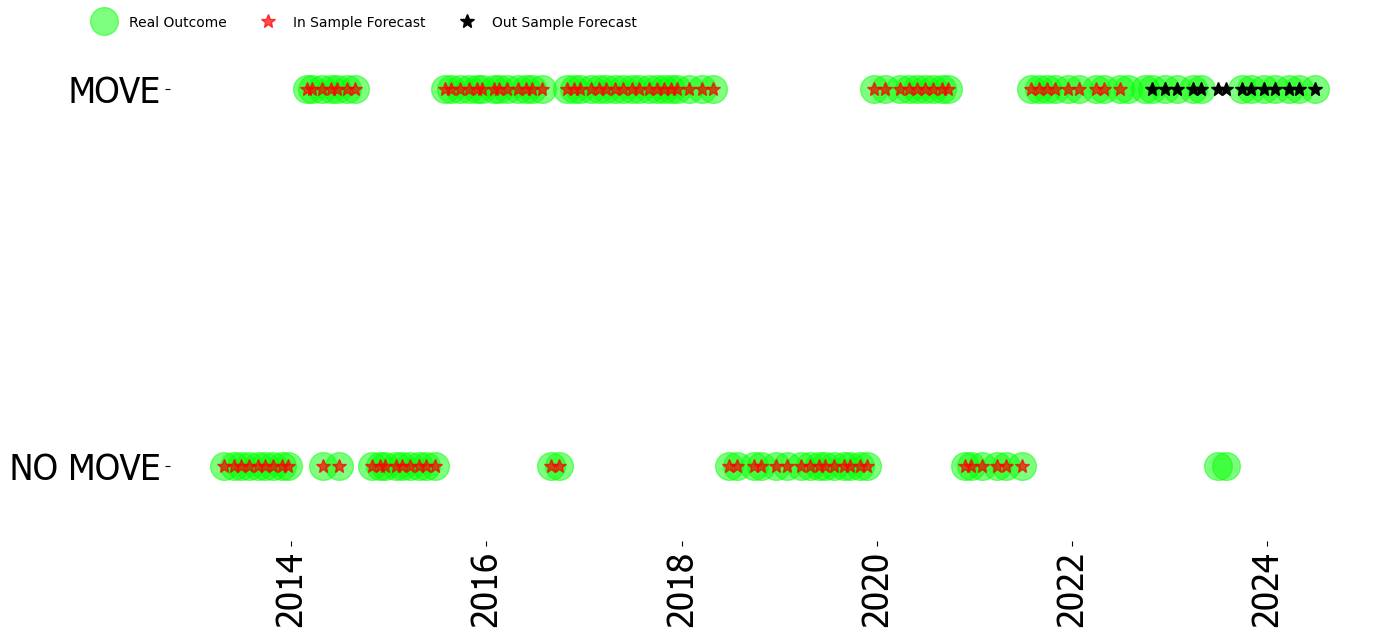

In [12]:
font = font_manager.FontProperties(family='Impact',weight='bold', style='normal', size=25)
tick_spacing1 = 1

fig = plt.figure()

ax1 = fig.add_subplot(1,1,1)
ax1.plot(df_comunicados['Fecha'],df_comunicados['Movimiento'],marker='o', linestyle='None',color='lime',label= 'Real Outcome', alpha=0.5,markersize=20)
ax1.plot(df_comunicados['Fecha'].iloc[0:99],test_pred_lr_all2[0:99],marker='*', linestyle='None',color='red',label= 'In Sample Forecast',alpha=0.7,markersize=10)
ax1.plot(df_comunicados['Fecha'].iloc[df_comunicados.shape[0]-14:df_comunicados.shape[0]],test_pred_lr_all[0:14],marker='*', linestyle='None',color='black',label= 'Out Sample Forecast',alpha=0.99,markersize=10)
ax1.legend(frameon=False,loc=1, bbox_to_anchor=(0.4, 1.02),ncol=10,markerscale=1)
plt.xticks(rotation=90)
plt.yticks(fontname = "Tahoma",fontsize=25)
plt.xticks(fontname = "Tahoma",fontsize=25)
ax1.title.set_fontfamily('arial')
ax1.axis([None, None, -0.2, 1.2])
plt.yticks(np.arange(0,2),['NO MOVE','MOVE'])
plt.box(on=None)

plt.subplots_adjust(bottom=0.1, right=2.0, top=1.2)

plt.show()

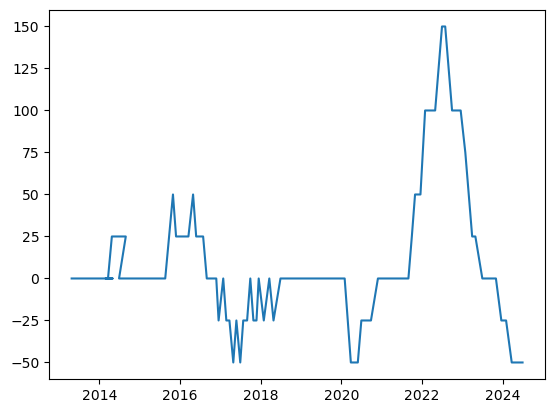

In [13]:
plt.plot(df_comunicados['Fecha'],df_comunicados['Cambio'])

In [14]:
lr_weights = pd.DataFrame(list(
    zip(
        bow_counts.get_feature_names(),
        lr_model_all.coef_[0])
    ),
    columns=['words','weights']
)
lr_weights.sort_values(['weights'],ascending = True)[:15]
lr_weights.sort_values(['weights'],ascending = True)[-15:]

C:\Users\andre\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,words,weights
32938,puntos basicos,0.063246
10401,demanda externa,0.064719
32905,punto,0.065372
15519,expectativas,0.067203
10107,decision,0.067629
30465,precios,0.068316
30191,porcentual,0.070193
32911,punto porcentual,0.070193
32930,puntos,0.071786
15970,externa,0.079830


In [15]:
#Random Forest instead of Logistic Regression
rf_model_all = RandomForestClassifier(n_estimators=100)
# Training the data
rf_model_all.fit(X_train_bow, y_train_bow)
# Generating predictions
test_pred_lr_prob = rf_model_all.predict_proba(X_test_bow)
test_pred_lr_all = rf_model_all.predict(X_test_bow)

print("F1 score: ", f1_score(y_test_bow[0:y_test_bow.shape[0]-2],test_pred_lr_all[0:test_pred_lr_all.shape[0]-2] ))
print("Accuracy: ", accuracy_score(y_test_bow[0:y_test_bow.shape[0]-2], test_pred_lr_all[0:test_pred_lr_all.shape[0]-2]) * 100)

F1 score:  0.9090909090909091
Accuracy:  83.33333333333334


In [16]:
# Predicting the output
test_pred_lr_prob = lr_model_all.predict_proba(X_test_bow)
test_pred_lr_all = lr_model_all.predict(X_test_bow)

test_pred_lr_all

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [17]:
# Term Frequency-Inverse Document Frequency (TF-IDF) method

# Create a vectorizer - we still feed in our stop words, although
# these are less relevant now as TF-IDF would weight them less 
# anyway.
tfidf_counts = TfidfVectorizer(tokenizer=word_tokenize,ngram_range=(1,4))

X_train_tfidf = tfidf_counts.fit_transform(df_comunicados_train['Texto_limpio'])
X_test_tfidf = tfidf_counts.transform(df_comunicados_test['Texto_limpio'])

# Create the classifier
lr_model_tf_idf = LogisticRegression(solver="liblinear", penalty='l1', C=10)

# Train the classifier
lr_model_tf_idf.fit(X_train_tfidf, y_train_bow)

# Predict the results
test_pred_lr_prob = lr_model_tf_idf.predict_proba(X_test_tfidf)
test_pred_lr_all = lr_model_tf_idf.predict(X_test_tfidf)

## Evaluating the model
print("F1 score: ", f1_score(y_test_bow[0:y_test_bow.shape[0]-2],test_pred_lr_all[0:test_pred_lr_all.shape[0]-2] ))
print("Accuracy: ", accuracy_score(y_test_bow[0:y_test_bow.shape[0]-2], test_pred_lr_all[0:test_pred_lr_all.shape[0]-2]) * 100)

F1 score:  0.9090909090909091
Accuracy:  83.33333333333334


In [18]:
test_pred_lr_all

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])